In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
import datetime as dt
import time
import talib as ta
from scipy.stats import skew,kurtosis
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

### Distribution selection criteria
1. Mesokurtic-Normal distribution
2. Leptokurtic-Tdistribution
3. Platykurtic-Uniform distribution

In [3]:
def statistical_analysis(ticker='^NSEI',p=20,confidence_interval=0.8,z_threshold=2):
    end_date = dt.datetime.now()
    start_date = end_date-dt.timedelta(days=365*p)
    df=yf.download(ticker,start_date,end_date)
    z_scores = np.abs((df - df.mean()) / df.std())
    
    # Identify the rows where any column has a Z-score greater than the threshold
    outlier_indices = np.any(z_scores > z_threshold, axis=1)

    # Remove the rows containing outliers from the dataset
    cleaned_data = df[~outlier_indices]
    # Sample dataset
    data = cleaned_data['Adj Close']
    # Calculate basic statistics
    mean = np.mean(data)
    median = np.median(data)
    mode = stats.mode(data).mode[0]
    std_dev = np.std(data)
    skewness = skew(data)

    # Interpret skewness
    if skewness > 0:
        print("The data is positively skewed.")
    elif skewness < 0:
        print("The data is negatively skewed.")
    else:
        print("The data is approximately symmetric.")

    kurtosis_value = kurtosis(data)

    # Interpret kurtosis
    if kurtosis_value > 0:
        print("The data is Leptokurtic (heavy-tailed).")
        distribution='Leptokurtic'
    elif kurtosis_value < 0:
        print("The data is Platykurtic (light-tailed).")
        distribution='Platykurtic'
    else:
        print("The data is Mesokurtic (similar to a normal distribution).")
        distribution='Mesokurtic'

    # Create probability distribution objects
    normal_dist = stats.norm(mean, std_dev)

    print("Mean:", mean)
    print("Median:", median)
    print("Mode:", mode)
    print("Standard Deviation:", std_dev)
    print("Skewness:",skewness)
    print("Kurtosis:",kurtosis_value)

    plt.hist(data, bins=30, density=True, alpha=0.7)
    plt.show()
    
    returns = df['Adj Close'].pct_change().dropna()

    # Fit a distribution (normal distribution in this example)
    if distribution=='Mesokurtic':
        fitted_distribution = stats.norm.fit(returns)
        mean_return, std_return = fitted_distribution
    elif distribution=='Leptokurtic':
        fitted_distribution = stats.t.fit(returns)
        dof,mean_return, std_return = fitted_distribution
    else:
        fitted_distribution = stats.uniform.fit(returns)
        mean_return, std_return = fitted_distribution
    
    # Calculate the price range for the desired confidence interval
    z_score = stats.norm.ppf(1 - (1 - confidence_interval) / 2)
    
    next_day_price = df['Adj Close'].iloc[-1] * (1 + mean_return)
    price_range = next_day_price * std_return * z_score

    lower_bound = next_day_price - price_range
    upper_bound = next_day_price + price_range
    
    print("\n predicted Price range for next day:",lower_bound ,upper_bound)
  

[*********************100%***********************]  1 of 1 completed
The data is negatively skewed.
The data is Leptokurtic (heavy-tailed).
Mean: 19538.428850446428
Median: 19543.099609375
Mode: 19381.650390625
Standard Deviation: 74.23662295705537
Skewness: -0.9752570889480616
Kurtosis: 0.2736041785357495


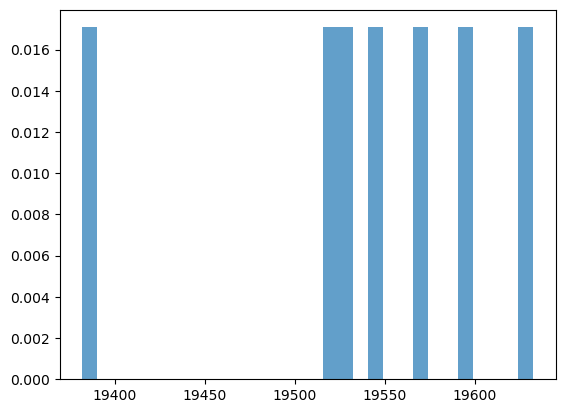


 predicted Price range for next day: 19286.897066992413 19542.211067446853


In [23]:
statistical_analysis(ticker='^NSEI',p=0.025,confidence_interval=0.8,z_threshold=2)

#### A leptokurtic distribution accompanied by positive skewness implies higher odds of positive outliers

In [5]:
def statistical_analysis_res(ticker='^NSEI',p=20,confidence_interval=0.8,z_threshold=2):
    end_date = dt.datetime.now()
    start_date = end_date-dt.timedelta(days=365*p)
    df=yf.download(ticker,start_date,end_date)
    z_scores = np.abs((df - df.mean()) / df.std())
    
    # Identify the rows where any column has a Z-score greater than the threshold
    outlier_indices = np.any(z_scores > z_threshold, axis=1)

    # Remove the rows containing outliers from the dataset
    cleaned_data = df[~outlier_indices]
    # Sample dataset
    data = cleaned_data['Adj Close']
    # Calculate basic statistics
    mean = np.mean(data)
    median = np.median(data)
    mode = stats.mode(data).mode[0]
    std_dev = np.std(data)
    skewness = skew(data)

    # Interpret skewness
    if skewness > 0:
        print("The data is positively skewed.")
    elif skewness < 0:
        print("The data is negatively skewed.")
    else:
        print("The data is approximately symmetric.")

    kurtosis_value = kurtosis(data)

    # Interpret kurtosis
    if kurtosis_value > 0:
        print("The data is Leptokurtic (heavy-tailed).")
        distribution='Leptokurtic'
    elif kurtosis_value < 0:
        print("The data is Platykurtic (light-tailed).")
        distribution='Platykurtic'
    else:
        print("The data is Mesokurtic (similar to a normal distribution).")
        distribution='Mesokurtic'

    returns = df['Adj Close'].pct_change().dropna()

    # Fit a distribution (normal distribution in this example)
    if distribution=='Mesokurtic':
        fitted_distribution = stats.norm.fit(returns)
        mean_return, std_return = fitted_distribution
    elif distribution=='Leptokurtic':
        fitted_distribution = stats.t.fit(returns)
        dof,mean_return, std_return = fitted_distribution
    else:
        fitted_distribution = stats.uniform.fit(returns)
        mean_return, std_return = fitted_distribution
    
    # Calculate the price range for the desired confidence interval
    z_score = stats.norm.ppf(1 - (1 - confidence_interval) / 2)
    
    next_day_price = df['Adj Close'].iloc[-1] * (1 + mean_return)
    price_range = next_day_price * std_return * z_score

    lower_bound = next_day_price - price_range
    upper_bound = next_day_price + price_range
    
    return lower_bound ,upper_bound

### To find optimum combination of z_threshold, confidence interval and time frame

In [6]:
# Statistical Study for different time frame,confidence interval and z_threshold
z_thresh=[]
Conf_int=[]
time_frame=[]
lower_range=[]
upper_range=[]
df_final=pd.DataFrame()
z_threshold_list=[1,2,3]
for tl in z_threshold_list:
    ci=[0.7,0.75,0.8,0.85,0.9,0.95]
    for cinterval in ci:
        periods=[20,15,10,5,3,2,1,0.5] # years
        for p in periods:
            print("\n Statistical analysis for period:",p,"years","and confidence interval:",cinterval*100,"z_threshold:",tl)
            lower_bound ,upper_bound=statistical_analysis_res(ticker='^NSEI',p=p,confidence_interval=cinterval,z_threshold=tl)
            z_thresh.append(tl)
            Conf_int.append(cinterval)
            time_frame.append(p)
            lower_range.append(lower_bound)
            upper_range.append(upper_bound)
            clear_output(wait=False)
df_final['z_thresh']=pd.DataFrame(z_thresh)
df_final['Conf_int']=pd.DataFrame(Conf_int)
df_final['time_frame']=pd.DataFrame(time_frame)
df_final['lower_range']=pd.DataFrame(lower_range)
df_final['upper_range']=pd.DataFrame(upper_range)
df_final.to_csv('summary.csv')

### Interpretation: 
1. A leptokurtic distribution accompanied by negative skewness implies at a greater risk, because of the higher odds of negative outliers. 
2. A leptokurtic distribution accompanied by positive skewness implies higher odds of positive outliers
3. A platykurtic distribution accompnied by low to moderately positive skewness implies stable returns and low risk


### Monte carlo simulation

[*********************100%***********************]  1 of 1 completed


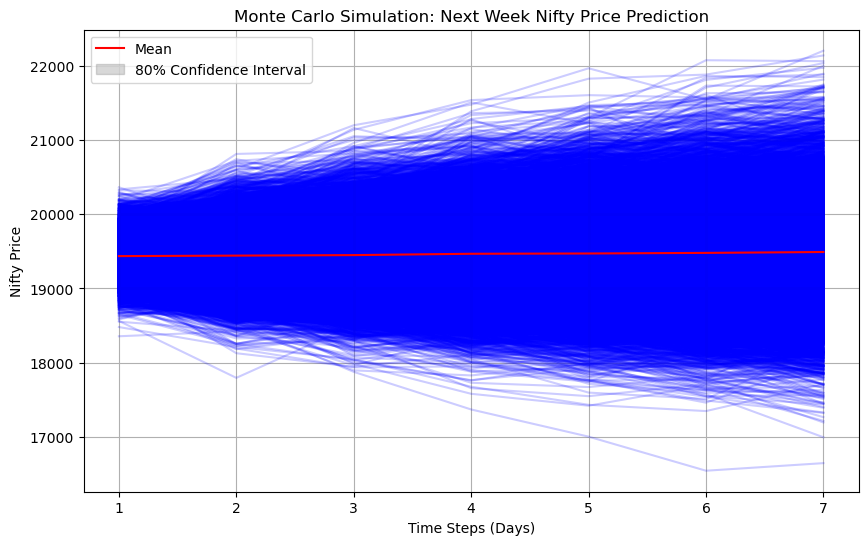

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ticker='^NSEI'
end_date = dt.datetime.now()
start_date = end_date-dt.timedelta(days=365*20)

# download data from yfinance
data=yf.download(ticker,start_date,end_date)

# Calculate log returns from historical prices
returns = np.log(1 + data['Adj Close'].pct_change()).dropna()

# Calculate historical mean and standard deviation of log returns
mean_return = returns.mean()
std_return = returns.std()

# Define the number of simulations and the forecast horizon (in this case, one week)
num_simulations = 10000
forecast_horizon = 7

# Calculate the drift and random component of the Brownian motion for the simulation
drift = mean_return - 0.5 * std_return ** 2
random_component = std_return * np.random.normal(size=(forecast_horizon, num_simulations))

# Create an array to store the simulated price paths
simulated_price_paths = np.zeros((forecast_horizon, num_simulations))

# Set the initial price as the last observed price in the data
initial_price = data['Adj Close'].iloc[-1]

# Simulate price paths using the geometric Brownian motion formula
for i in range(num_simulations):
    simulated_price_paths[:, i] = initial_price * np.exp(np.cumsum(drift + random_component[:, i]))

# Calculate the mean and standard deviation of the simulated price paths for each time step
simulated_mean_prices = np.mean(simulated_price_paths, axis=1)
simulated_std_prices = np.std(simulated_price_paths, axis=1)

# Calculate the upper and lower bounds of the 80% confidence interval
upper_bound = simulated_mean_prices + 1.28 * simulated_std_prices / np.sqrt(num_simulations)
lower_bound = simulated_mean_prices - 1.28 * simulated_std_prices / np.sqrt(num_simulations)

# Plot the simulated price paths and the confidence interval
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, forecast_horizon + 1), simulated_price_paths, alpha=0.2, color='b')
plt.plot(np.arange(1, forecast_horizon + 1), simulated_mean_prices, color='r', label='Mean')
plt.fill_between(np.arange(1, forecast_horizon + 1), upper_bound, lower_bound, alpha=0.3, color='gray', label='80% Confidence Interval')
plt.xlabel('Time Steps (Days)')
plt.ylabel('Nifty Price')
plt.title('Monte Carlo Simulation: Next Week Nifty Price Prediction')
plt.legend()
plt.grid(True)
plt.show()
